In [1]:
import numpy as np
import cv2
import pickle
import io
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Image
import scipy
from scipy import interpolate

%matplotlib inline

In [2]:
import sys
sys.path.append('/home/kwk/share/mizuho/share/code')
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/preprocess/")

In [3]:
from get_data import get_data
import importlib
import img_shows
importlib.reload(img_shows)
from img_shows import *

In [4]:
df_market, df_economy = get_data()

In [5]:
delta = 22

In [6]:
usgb10 = df_market.USGB10.pct_change(delta)

In [7]:
ussp500 = df_market.US_SP500.pct_change(delta)

## 実際の工程はここから

In [8]:
def to_monochrome(img):
    img_size = img.shape[0]
    new_img = np.zeros((img_size, img_size))
    for i in range(img_size):
        for j in range(img_size):
            new_img[i, j] = 0.0 if np.all(img[i, j] == 255) else 1.0
    return new_img

In [9]:
def img_generator(start, end, size = 64, lw = 1.0):
    # fig setting
    fig = plt.figure(dpi=1, figsize=(size, size))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    
    # read data
    x = usgb10[start:end]
    y = ussp500[start:end]
    
    # plot
    # plt.plot(-x, y, marker=".")
    plt.plot(-x, y, lw=lw)
    # プロット画像を直接メモリで渡す                                                   
    buf = io.BytesIO() # bufferを用意
    plt.savefig(buf, format='png') # bufferに保持
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
    dst = cv2.imdecode(enc, 1) # デコード
    dst = dst[:,:,::-1] # BGR->RGB
    plt.close()
    img = to_monochrome(dst)
    return img

In [10]:
import datetime

years = [1962 + i  for i  in range(58) ]
months = [ i+2  for i  in range(12)  ]
days = [ i+1  for i  in range(31) ]

start_and_end = list()
for year in years:
    for month in months:
        for day in days:
            try:
                start = datetime.date(year, month, day)
                if month != 12:
                    end  = datetime.date(year, month+1, day)
                else:
                    end  = datetime.date(year+1, 1, day)
                start_and_end.append( ( str(start), str(end) ) )
            except Exception as e:
                pass

### データ抽出期間

In [11]:
def spline(x,y,point,deg):
    tck,u = interpolate.splprep([x,y],k=deg,s=0) 
    u = np.linspace(0,1,num=point,endpoint=True) 
    spline = interpolate.splev(u,tck)
    return spline[0],spline[1]

In [12]:
def img_plotter(start, end, size = 64, lw = 1.0):
    # fig setting
    fig = plt.figure(dpi=1, figsize=(size, size))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    
    # read data
    x = usgb10[start:end]
    y = ussp500[start:end]
    
    # plot
    # plt.plot(-x, y, marker=".")
    a, b = spline(-x, y, 100, 2)
    plt.plot(a, b, lw=lw)
    # プロット画像を直接メモリで渡す                                                   
    buf = io.BytesIO() # bufferを用意
    plt.savefig(buf, format='png') # bufferに保持
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
    dst = cv2.imdecode(enc, 1) # デコード
    dst = dst[:,:,::-1] # BGR->RGB
    plt.close()
    img = to_monochrome(dst)
    return img

In [13]:
len(start_and_end)

19154

In [14]:
data_pkls = "../data_pkls/"

In [15]:
lw = 200

In [16]:
pos = 111

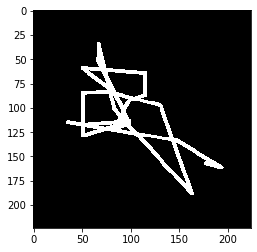

In [18]:
img = img_generator(start_and_end[pos][0],  start_and_end[pos][1], size=224, lw = lw)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

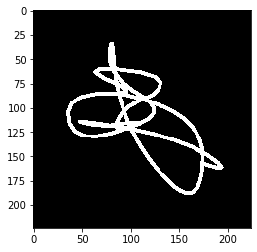

In [19]:
img = img_plotter(start_and_end[pos][0],  start_and_end[pos][1], size=224, lw = lw)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

In [20]:
poses = list(range(100, 104))
lw = 100

In [21]:
# imdisp(poses, usgb10, ussp500, start_and_end)

In [22]:
poses = list(range(100, 104))
lw = 100

In [23]:
poses = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

In [24]:
# imdisp_abs(poses, usgb10, ussp500, start_and_end)

# スケールはそのままで、位置だけ中心にする

In [25]:
def find_hw():
    max_h, max_w = 0, 0
    for i in range(19154):
        x = usgb10[start_and_end[i][0]:start_and_end[i][1]]
        y = ussp500[start_and_end[i][0]:start_and_end[i][1]]
        max_w = x.max() - x.min() if (x.max() - x.min()) > max_w else max_w
        max_h = y.max() - y.min() if (y.max() - y.min()) > max_h else max_h
    return max_w, max_h

In [26]:
max_w, max_h = find_hw()

In [27]:
print(max_w, max_h)

0.7013543007443057 0.41413084844130343


In [35]:
print(usgb10.max() - usgb10.min(), ussp500.max() - ussp500.min())

1.0558213716108453 0.5607756581851283


In [36]:
def gen_same_scale(start, end, size = 224, lw = 1.0):
    # fig setting
    fig = plt.figure(dpi=1, figsize=(size, size))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    
    # read data
    x = usgb10[start:end]
    y = ussp500[start:end]
    
    x_min = x.min()
    y_min = y.min()
    plt.xlim([x_min, x_min + max_w])
    plt.ylim([y_min, y_min + max_h])
    
    # plot
    # plt.plot(-x, y, marker=".")
    plt.plot(-x, y, lw=lw)
    # プロット画像を直接メモリで渡す                                                   
    buf = io.BytesIO() # bufferを用意
    plt.savefig(buf, format='png') # bufferに保持
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
    dst = cv2.imdecode(enc, 1) # デコード
    dst = dst[:,:,::-1] # BGR->RGB
    plt.close()
    img = to_monochrome(dst)
    return img

In [29]:
def imgs_show(poses, lw=1.0, figsize=(15.0, 15.0)):
    plt.clf()
    fig = plt.figure(figsize=figsize)
    for i, pos in enumerate(poses):
        ax = fig.add_subplot(np.ceil(np.sqrt(len(poses))).astype("int64"), np.ceil(np.sqrt(len(poses))).astype("int64"), i + 1)
        img = gen_same_scale(start_and_end[pos][0], start_and_end[pos][1], lw=lw)
        ax.imshow(img, cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
    fig.tight_layout()
    plt.show()

In [37]:
poses = np.array([(i + 1) * 100 for i in range(64)],dtype="int64")
# poses += 500

In [31]:
# poses = list(range(64))

<Figure size 432x288 with 0 Axes>

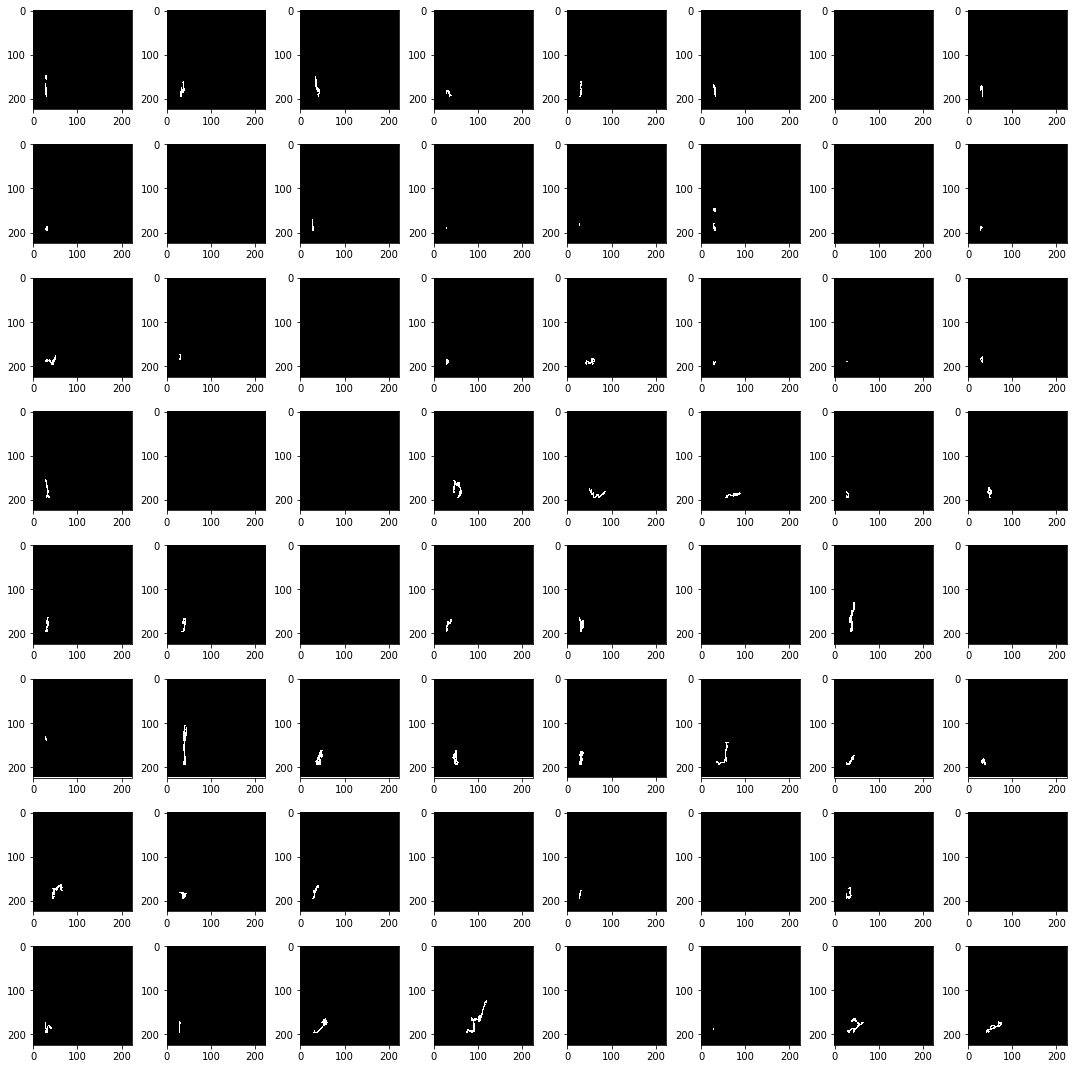

In [38]:
imgs_show(poses, lw=150)

<Figure size 432x288 with 0 Axes>

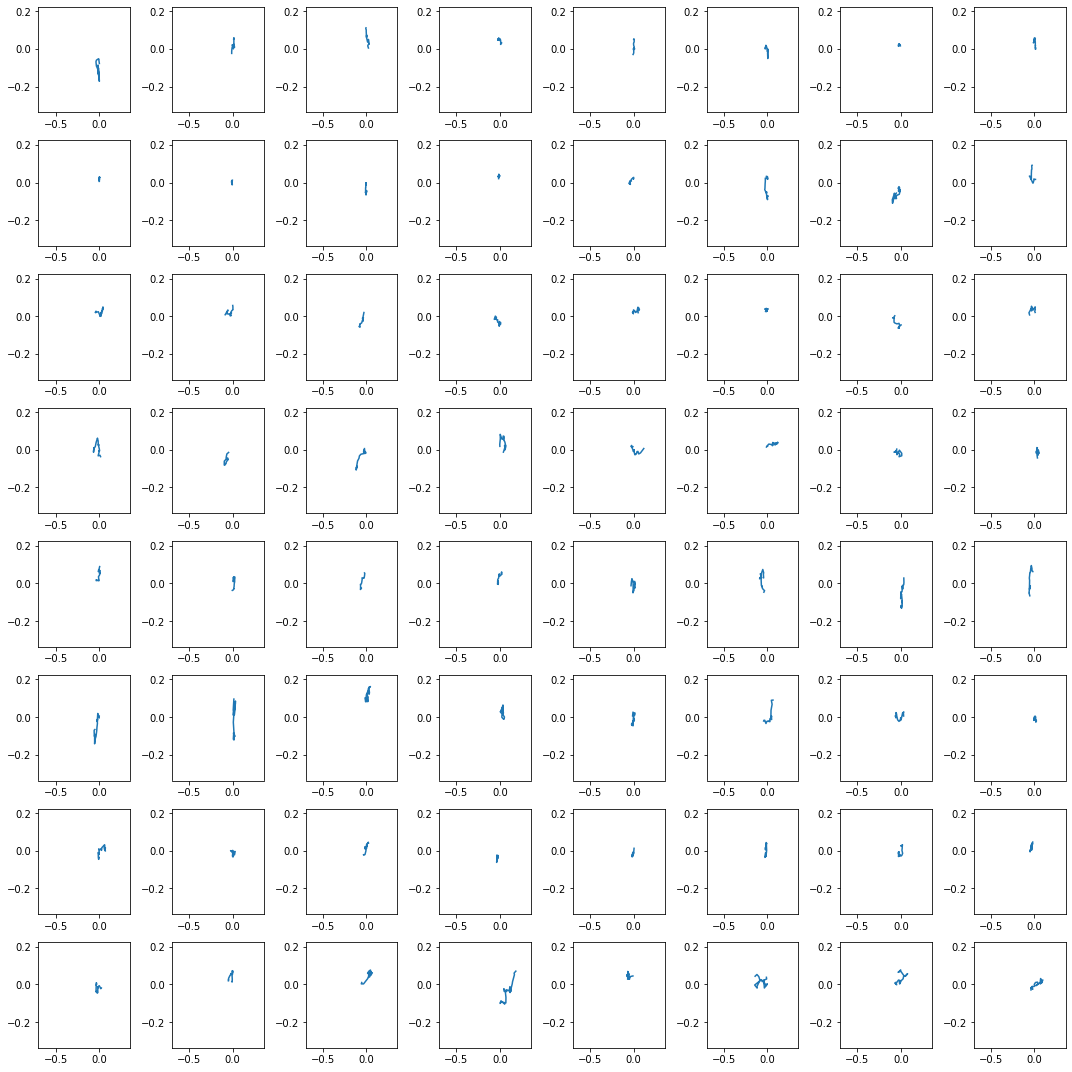

In [40]:
imdisp_abs(poses, usgb10, ussp500, start_and_end)

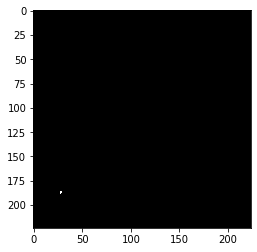

In [45]:
np.set_printoptions(threshold=np.inf)
img = gen_same_scale(start_and_end[(61 + 1) * 100][0], start_and_end[(61 + 1) * 100][1], lw=lw)
plt.clf()
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

<Figure size 432x288 with 0 Axes>

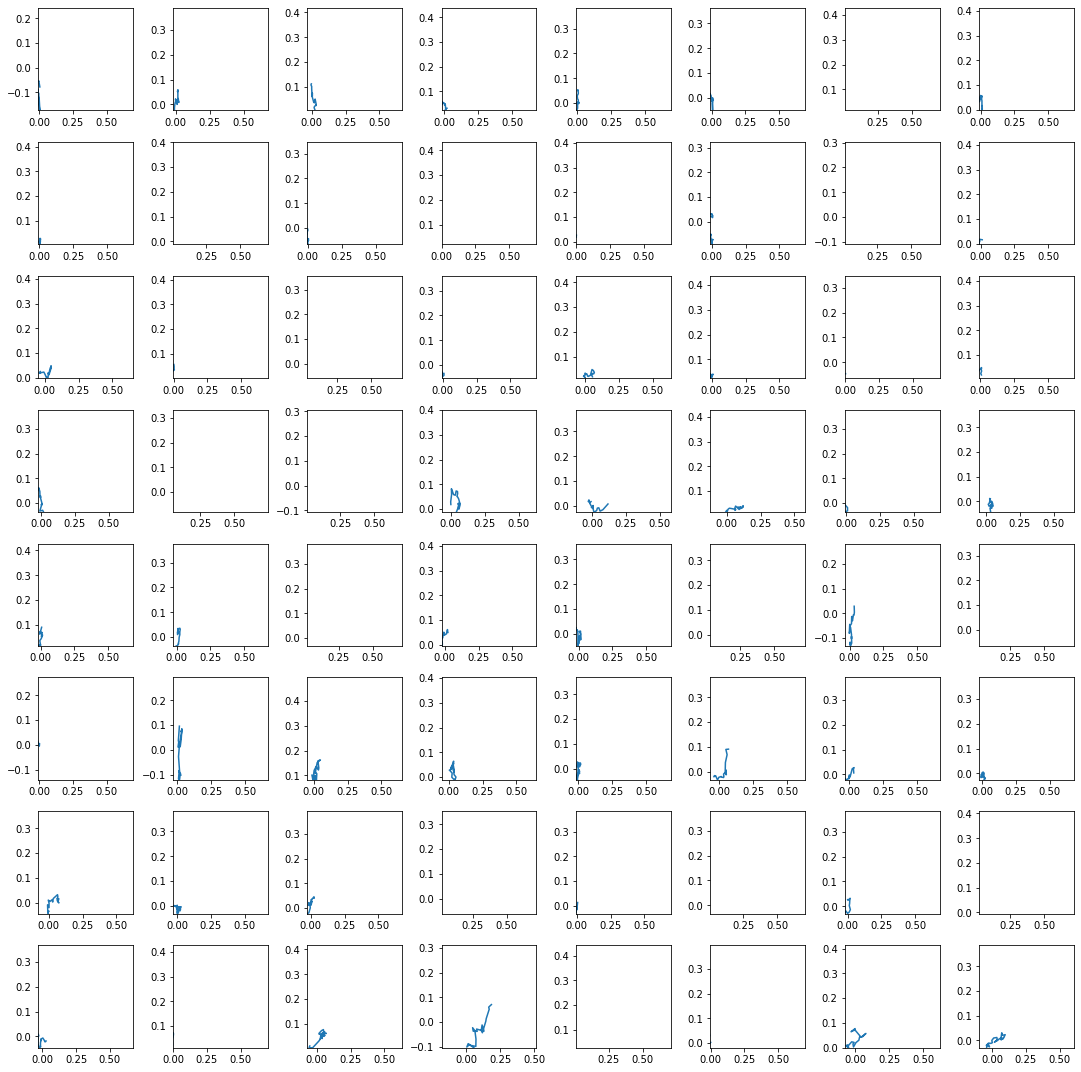

In [39]:
imdisp_same_scale(poses, usgb10, ussp500, start_and_end, max_w, max_h)

<Figure size 432x288 with 0 Axes>

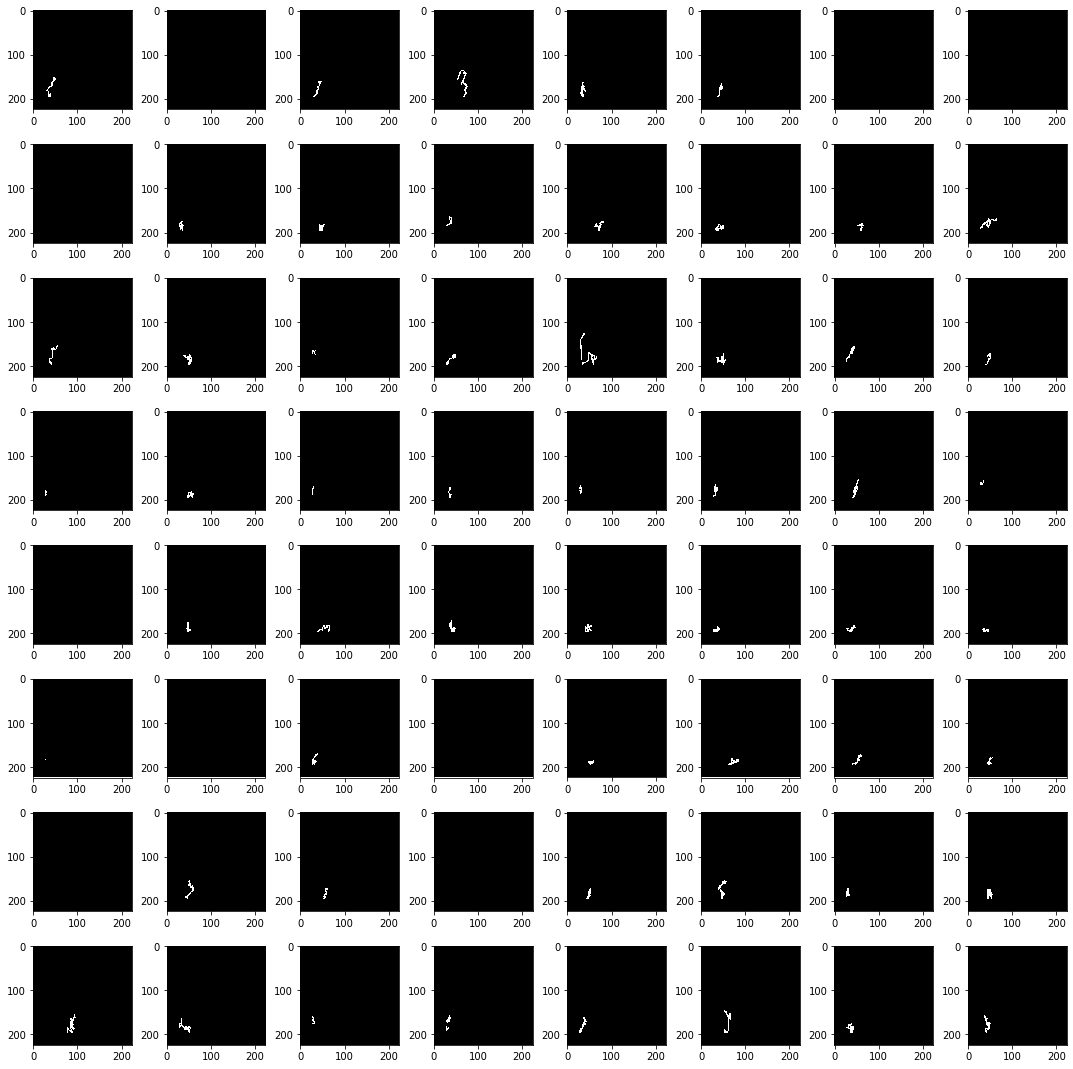

In [34]:
poses = np.array([(i + 1 + 64) * 100 for i in range(64)],dtype="int64")
imgs_show(poses, lw=120)

### データ作成

In [ ]:
lw = 120

In [21]:
%%time
img_list = []
for i in tqdm( range(19154 // 4) ):
    img = gen_same_scale(start_and_end[i][0], start_and_end[i][1], lw=lw, size=224) # 1962-01-01 ~ 2020-02-01
    img_list.append(img)

100%|██████████| 8000/8000 [28:10<00:00,  4.73it/s]  


CPU times: user 27min 56s, sys: 17.4 s, total: 28min 14s
Wall time: 28min 10s


In [22]:
img_filename = "imgs224_" + str(lw) + "_1.pkl"

In [23]:
with open(data_pkls + img_filename, "wb") as f:
    pickle.dump(img_list, f)

In [24]:
img_list = []
for i in tqdm( range(19154 // 4, 19154 // 4 * 2) ):
    img = img_generator(start_and_end[i][0],  start_and_end[i][1] , 22, size=128, lw = lw) # 1962-01-01 ~ 2020-02-01
    img_list.append(img)

100%|██████████| 8000/8000 [28:27<00:00,  4.68it/s]   


In [25]:
img_filename = "imgs224_" + str(lw) + "_2.pkl"

In [26]:
with open(data_pkls + img_filename, "wb") as f:
    pickle.dump(img_list, f)

In [27]:
img_list = []
for i in tqdm( range(19154 // 4 * 2, 19154 // 4 * 3) ):
    img = img_generator(start_and_end[i][0],  start_and_end[i][1] , 22, size=128, lw = lw) # 1962-01-01 ~ 2020-02-01
    img_list.append(img)

100%|██████████| 3154/3154 [11:26<00:00,  4.59it/s]  


In [28]:
img_filename = "imgs224_" + str(lw) + "_3.pkl"

In [29]:
with open(data_pkls + img_filename, "wb") as f:
    pickle.dump(img_list, f)

In [ ]:
img_list = []
for i in tqdm( range(19154 // 4 * 3, 19154) ):
    img = img_generator(start_and_end[i][0],  start_and_end[i][1] , 22, size=128, lw = lw) # 1962-01-01 ~ 2020-02-01
    img_list.append(img)

In [ ]:
img_filename = "imgs224_" + str(lw) + "_4.pkl"

In [ ]:
with open(data_pkls + img_filename, "wb") as f:
    pickle.dump(img_list, f)

In [30]:
date_filename = "dates.pkl"
with open(date_filename, "wb") as f:
    pickle.dump(start_and_end, f)